<a href="https://colab.research.google.com/github/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/notebooks/Week_6/Week_6_Lecture_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lecture 2: Explaining CNNs: Early Methods



In [1]:
#@title 
from ipywidgets import widgets
out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"a4TDSLGhKi8", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)
display(out1)

Output()

In [2]:
#@title 
from IPython import display as IPyDisplay
IPyDisplay.HTML(
    f"""
  <div>
    <a href= "https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Slides/Week_6/DL4CV_Week06_Part02.pdf" target="_blank">
    <img src="https://github.com/DL4CV-NPTEL/Deep-Learning-For-Computer-Vision/blob/main/Data/Slides_Logo.png?raw=1"
  alt="button link to Airtable" style="width:200px"></a>
    </div>""" )

Let's start with some imports!

In [4]:
from torchvision import models
import torchvision.transforms as transforms
import torch.nn as nn
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [5]:

# get the model pretrained on Imagenet which is easily available from pytorch
model = models.resnet50(pretrained=True)

# get the reference to the last layer of the convolution
final_conv_layer = model._modules.get('layer4')

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [6]:
# This class stores the feature maps of the last convolutional layer of the image, after a forward pass.
class FeatureBuffer():

    def __init__(self, m): 
        self.hook = m.register_forward_hook(self.hook_fn)
    
    def hook_fn(self, module, _input, _output): 
        self.features = _output

    def remove(self): 
        self.hook.remove()

# Register hook.
fb = FeatureBuffer(final_conv_layer)

In [7]:
# Let's preprocess the data to get the desired results
transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

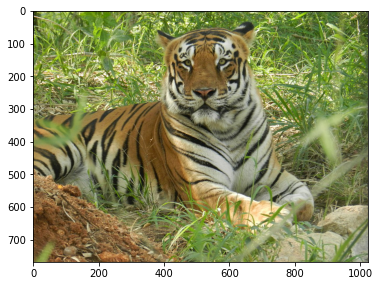

In [9]:
# Example picture.
from PIL import Image
plt.figure(figsize=(6, 6))
img = Image.open('./bulbul.jpg').convert('RGB')
plt.imshow(img)
plt.show()


In [10]:
# Prepare input, from size [3, 224, 298] to [1, 3, 224, 298]
input_tensor = transform(img).unsqueeze(0)

# Model in evaluation mode.
model = model.eval()

# Get probabilities and feature maps.
out = model(input_tensor)
feature_maps = fb.features

# 1000 classes, and 2028xWxH feature maps ((W,H)depend on image's size after pre-processing).
print("Output's shape: ", out.shape)
print("Feature maps's shape: ", feature_maps.shape)

Output's shape:  torch.Size([1, 1000])
Feature maps's shape:  torch.Size([1, 2048, 7, 10])


In [11]:
# Get probs from output as torchvision models do not have this final layer.
# If you do not care about the score, then you only need to find the max and ommit this line.

probs = torch.nn.functional.softmax(out[0], dim=0)

# Find out which class image belongs.
score, _class = torch.max(probs, dim=0)
print("Score: ", score.item(), " Class: ", _class.item(), "- Tiger")

Score:  0.8153239488601685  Class:  292 - Tiger


In [12]:
# Get weights and biases for fully conected linear layer.
weights_and_biases = list(model._modules.get('fc').parameters())
print("Weights's shape: ", weights_and_biases[0].shape)
print("Biases's shape: ", weights_and_biases[1].shape)

# Get weights for the class's neuron.
class_weights = weights_and_biases[0][_class]
print("Class weights's shape :", class_weights.shape)

Weights's shape:  torch.Size([1000, 2048])
Biases's shape:  torch.Size([1000])
Class weights's shape : torch.Size([2048])


In [13]:
# Weights must be reshaped to match feature maps's dimension.
class_weights = class_weights.reshape((-1, 1, 1))
print("Class weights's shape :", class_weights.shape)

# We can also reduce one empty dimension (first one) of the feature maps.
feature_maps = feature_maps.flatten(start_dim=0, end_dim=1)
print("Feature maps's shape: ", feature_maps.shape)

Class weights's shape : torch.Size([2048, 1, 1])
Feature maps's shape:  torch.Size([2048, 7, 10])


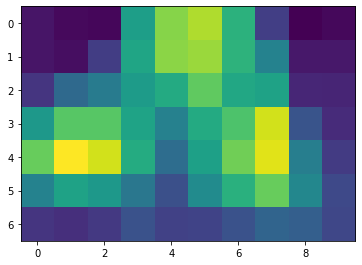

In [14]:
# Get class_activation maps
class_activation_maps = np.array(torch.sum(feature_maps * class_weights, dim=0).detach(), dtype=np.float32)
plt.figure(figsize=(6, 6))
plt.imshow(class_activation_maps)
plt.show()

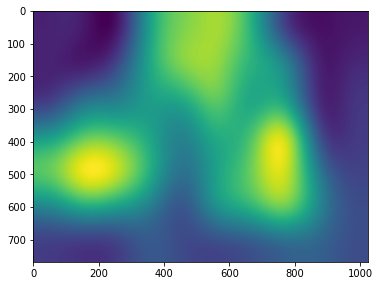

In [15]:
"""
There are many types of interpolation, like cv2.INTER_NEAREST, cv2.INTER_LINEAR etc we use cv2.INTER_LANCZ054 to make up for low quality of 
the class activation map
"""

# Resize tensor to match original image's size.
resized_cam = cv2.resize(class_activation_maps, dsize=img.size, interpolation=cv2.INTER_LANCZOS4)
plt.figure(figsize=(6, 6))
plt.imshow(resized_cam)
plt.show()

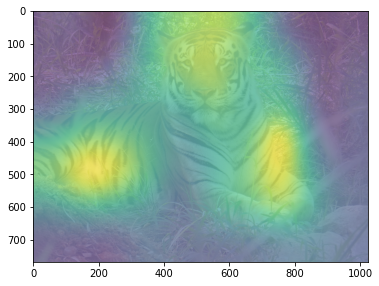

In [16]:
# Visualization of the class activation map, over the original image.
plt.figure(figsize=(6, 6))
plt.imshow(img, alpha=0.4)
plt.imshow(resized_cam, alpha=0.6)
plt.show()

REFERENCES:


http://cnnlocalization.csail.mit.edu/ : some results by the authors.

https://github.com/zhoubolei/CAM : official code for CAM. 

https://medium.com/intelligentmachinesimplementation-of-class-activation-map-cam-with-pytorch-c32f7e414923